# Librerias

In [69]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, RMSprop, Adam
from matplotlib import pyplot as plt
import numpy as np
import math 

# Cración de Capa entrenable

In [70]:
loss_tracker = keras.metrics.Mean(name="loss") #El promedio de loss
class Graficador_funcion(Sequential):
    @property
    def metrics(self):
        return [loss_tracker] #igual cambia el loss_tracker

    def train_step(self, data):
        batch_size =100 #Calibra la resolucion de la funcion
        x = tf.random.uniform((batch_size,1), minval=-1, maxval=1)
        #Creamos un vector columna con valores random entre -1 a 1
            #Este será el intervalo de nuestra función
        funcion = tf.math.cos(2.*x)
        #Crea las y's correctas

        #Calculamos el gradiente de loss
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            #Dice al modelo que está en modo entrenamiento
            loss = tf.math.reduce_mean(tf.math.square(y_pred-funcion))
            #Error de minimos cuadrados
            #Entre más cerca estén del cero, mejor es nuestro modelo
            # Pues diría que y_pred = funcion

        grads = tape.gradient(loss, self.trainable_weights)
        #Guardamos las derivadas de loss respecto a los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #Esto viene de Sequential
            #toma los gradientes calculados durante
            #la retropropagación y los utiliza para
            #actualizar los valores de las variables
            #entrenables del modelo utilizando el
            #algoritmo de optimización especificado por el optimizador.
        #actualiza metricas
        loss_tracker.update_state(loss)

        return {"loss": loss_tracker.result()}

## Creación de capa polinomio grado 3

In [99]:
#Ahora haremos una capa usando el coseno como base
class Polinomio_grado3(tf.keras.layers.Layer):

    def __init__(self):
        super(Polinomio_grado3,self).__init__()
        self.num_outputs = 4 # a_o, a_1, a_2, a_3
        self.freq = tf.ones([4,])
        #Crea un array = [ 1.,  1.,  1.,  1.]
        self.kernel = self.add_weight("kernel",
                                shape=[self.num_outputs])
        #Aquí le decimos a nuestra red que entrene 4 variables a's , ahora llamadas w's

    def call(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        if (inputs.shape == ()):
            inputs=(inputs,)
            #de tf.Tensor(x_1, shape=(), dtype=int32) ----------> pasa a
                            #(<tf.Tensor: shape=(), dtype=int32, numpy=x_1>,)
        elif (len(inputs.shape)==1):
            #si inputs = tf.Tensor([[x_1,..., x_{num_inputs}]], shape=(num_inputs,), dtype=int32)
            inputs=tf.expand_dims(inputs, axis=1)
            #de tf.Tensor([[x_1,..., x_{num_inputs}]], shape=(num_inputs,), dtype=int32) -------> pasa a
                        #tf.Tensor([[x_1] ,..., [x_{num_inputs}]], shape=(num_inputs, 1), dtype=int32)    
        batch = tf.shape(inputs)[0]
        #tf.Tensor(1, shape=(), dtype=int32)
        self.freq_b = tf.ones([batch,1])*self.freq
        #tf.ones([batch,1])------>
                    #tf.Tensor(
                    # [[[x_1]]
                    #   ...
                    #  [[x_{num_outpus}]]], shape=(num_inputs, 1, 1), dtype=float32) ----->
                            #tf.Tensor(
                            # [[[1]]
                            #   ..
                            #[[1]]], shape=(num_inputs, 1), dtype=float32)
        #self.freq_b ---->
        #tf.Tensor(
        # [[1. 1. 1. 1.]
        #     ...
        # [1. 1. 1. 1.]], shape=(num_inputs, 4), dtype=float32)
        base = tf.identity(self.freq_b)  # Creamos una copia del tensor original
        base = self.freq_b*inputs
        powers = tf.range(4.)  # Potencias de 0 a 3 para un polinomio de grado 3
        base = tf.pow(base, powers)
               #base = tf.tensor_scatter_nd_update(base,
                                                   #[[i, j]],
                                                   #[tf.pow(inputs[i,0], j)])
        #tf.Tensor(
        # [[x_1**0   x_1**1   x_1**2    x_1**3 ]
        #                       ...
        # [x_{num_inputs}**0 ... x_{num_inputs}**3]], shape=(num_inputs, 4), dtype=float32)
        res = tf.tensordot(base,self.kernel,1)
        #Las dimensiones concuerdan para el producto (num_inputs,4)*(4,)
        #tf.Tensor(
        #[w_1*x_1**0+ ... +w_2*x_1**3, ... ,w_4*x_{num_inputs}**0+ ... +w_4*x_{num_inputs}**3 ], shape=(num_inputs,), dtype=float32)
        return tf.expand_dims(res, axis=1)
        #tf.Tensor(
        #[ [w_1*x_1**0+ ... +w_2*x_1**3
        #       ...
        #  [w_4*x_{num_inputs}**0+ ... +w_4*x_{num_inputs}**3 ], shape=(4,1), dtype=float32)

# Entrenamiento

In [100]:
model = Graficador_funcion()
model.add(Polinomio_grado3())
model.build(input_shape=(1,))
model.summary()

Model: "graficador_funcion_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 polinomio_grado3_5 (Polinom  (1, 1)                   4         
 io_grado3)                                                      
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [101]:
x = tf.linspace(-1, 1, 100)
#x = tf.expand_dims(x, axis=-1)  # Agregar una dimensión al final del tensor

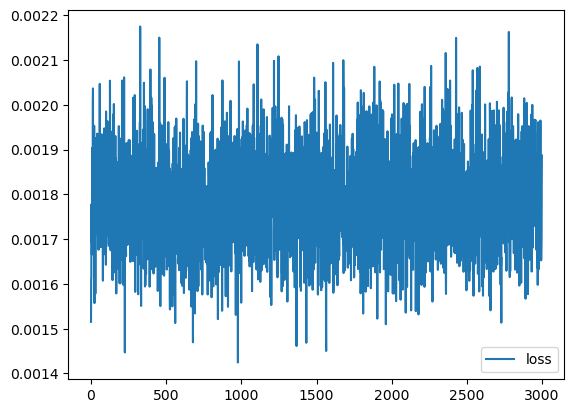

In [108]:
model.compile(optimizer=SGD(learning_rate=0.0001), metrics=['loss'])
history = model.fit(x,epochs=3000,verbose=0)
plt.plot(history.history["loss"], label='loss')
plt.legend()
plt.show()

graficamos la funcion

[<tf.Variable 'kernel:0' shape=(4,) dtype=float32, numpy=
array([ 9.5084721e-01,  1.4375180e-03, -1.4886701e+00, -2.3055742e-03],
      dtype=float32)>]
4/4 [==============================] - 0s 2ms/step


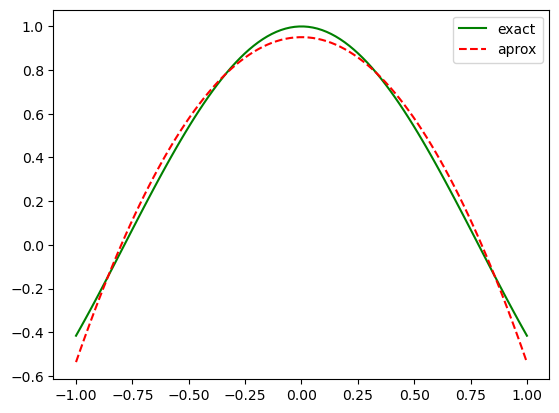

In [109]:
print(model.layers[0].trainable_weights)
y_pred = model.predict(x)
plt.plot(x,tf.math.cos(2.*x) , label="exact", color='green')
plt.plot(x,y_pred,label="aprox", color='red', linestyle='--')
plt.legend()
plt.show()